# Film dosimetry

## Prerequisites for the image


* A minimum distance of 5 mm between films.
* Rectangular films aligned to the sides of the scanner.
* The tiff image has to be 16-bit per channel, RGB.
* The image must have the full width of the scanner to account for lateral response artifact.

This is a common example for film calibration. 

![example scanned films](../assets/cal_example_v2.png)

Optional

Optical filters are added as a quality control test for error detection. Useful for example if auto correction for color or brightness has been applied unconsciously. Also, as a way to measure inter-scan reproducibility of the lamp/detector system.

## Usage

Start importing the load funtion and LUT class.

In [1]:
from Dosepy.image import load
from Dosepy.calibration import LUT

Read the tiff file for film calibration

In [2]:
# Change this to your file path
path_to_file = "/home/luis/Dosepy/tests/unit/fixtures/CAL20241106_001.tif"

cal_image = load(path_to_file)

Create a LUT object with the image as argument. This will store all the data needed for calibration.

In [3]:
cal = LUT(cal_image)

Dosepy automatically detects each object in the image.

Create central rois on each film and show them.

<Axes: >

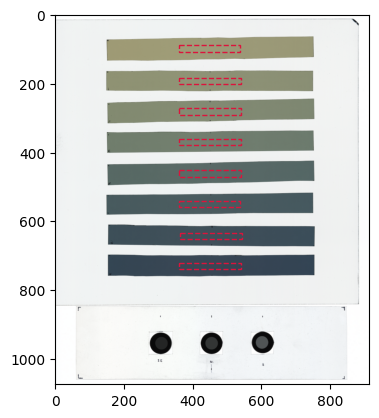

In [4]:
cal.set_central_rois()

cal.plot_rois()

Change the ROI size to 16 x 8 mm

<Axes: >

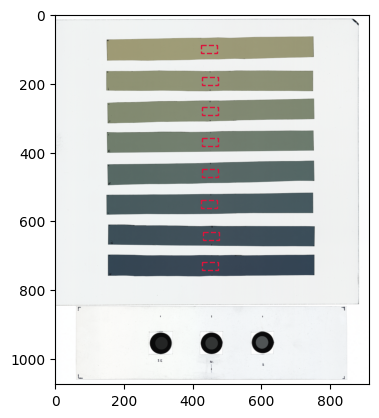

In [5]:
cal.set_central_rois(size = (16, 8))
cal.plot_rois()

To set-up the **calibration or cal** object we need to perform the following steps:

* Set the imparted doses to the films [Gy].
* Compute the lut.
* Optional, apply a filer of size of 3 pixels for noise reduction.

In [6]:

cal.set_doses([0, 0.5, 1, 2, 4, 6, 8, 10])

cal.compute_central_lut(filter=3)

## Show results

Plot the calibration curve, using the red channel and rational function of the form

$$ y = -c + \frac{b}{x-a} $$

where $$ x = \frac{I_0}{I} $$ represents the film response as the quotient of intensities of unexposed and exposed films, respectively.

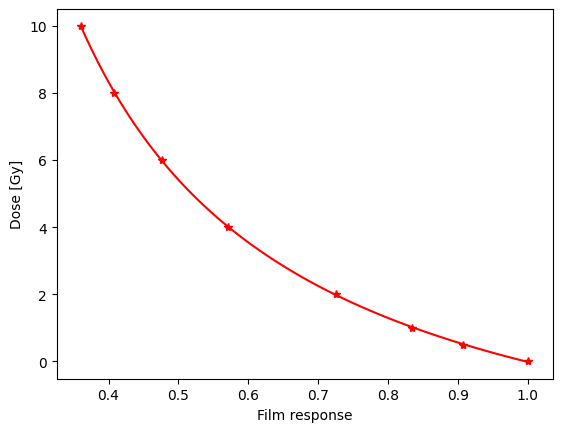

In [7]:
cal.plot_fit(fit="rational", channel="red")

Plot dose uncertainty with **plot_dose_fit_unertainty** method

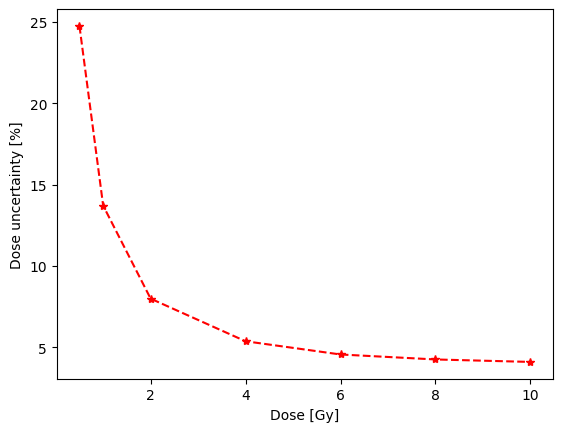

In [8]:
cal.plot_dose_fit_uncertainty(fit="rational", channel="red")

## Lateral response

Lateral response artifact is handled by computing a calibration curve at every milimeter in lateral direction. 

 If film irradiation has been done in a x-ray beam from a linear acelerator, we need to account for the "beam horns". To do that, we need to load a relative dose profile of the field used. In this example, a 6 MV beam of size 150 mm x 150 mm and 5 mm deep was used for film calibration.

The file must have an array of two columns:

* First column should be for positions, given in mm, with 0 being at beam center.

* Second column should be the relative values [%], normalized to 100 at center.

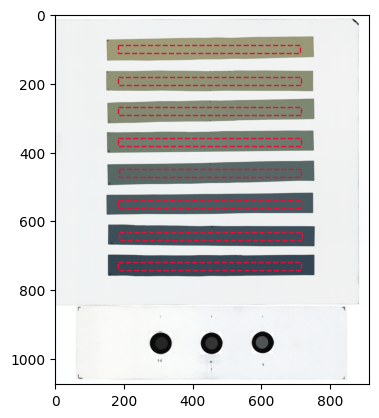

In [9]:
cal = LUT(cal_image)

cal.set_central_rois(size = (180, 8))
cal.set_doses([0, 0.5, 1, 2, 4, 6, 8, 10])
cal.plot_rois()

cal.set_beam_profile("/home/luis/Dosepy/tests/unit/fixtures/CAL/BeamProfile.csv")  # Change this to your path

Next we need to call the **compute_lateral_lut()** (instead of compute_central_lut()). We'll use a filter of size 3 pixels.

In [10]:
cal.compute_lateral_lut(filter=3)

Optional, show green intensity values on lateral direction. The zero position is located in the center of the image, i.e. the center of the scanner if the full width has been acquired.

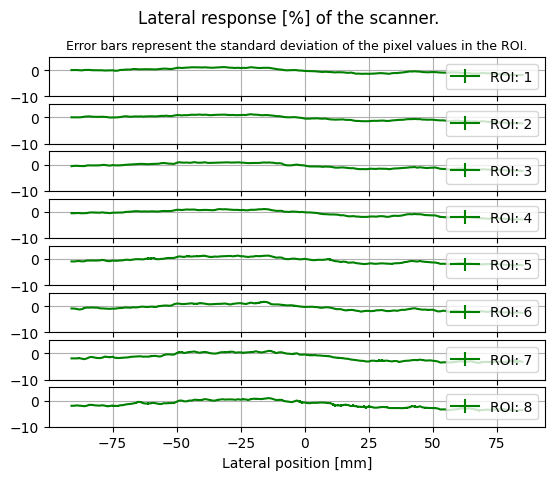

In [11]:
cal.plot_lateral_response(channel="green")

We can use the green channel and a polynomial fit function of the form

$$  y = ax + bx^n $$

To see the calibration curve at say, position 5 mm from the center, we can use the plot_fit() method.

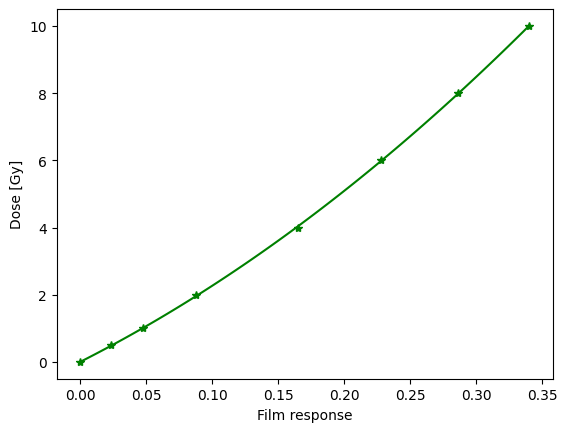

In [12]:
cal.plot_fit(
    fit="polynomial",
    channel="green",
    position=5,
    )

Show uncertainty at 5 mm.

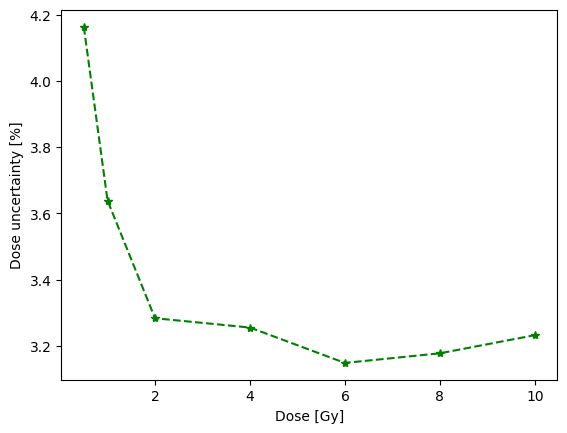

In [13]:
cal.plot_dose_fit_uncertainty(
    position = 5,
    fit="polynomial",
    channel="green"
    )

## Load multiple files for noise reduction

In [14]:
from Dosepy.image import load_multiples

In [15]:
files = [
    "/media/luis/TOMO/Tiff Films/EBT4/6NOV24_CAL/CAL20241106_001.tif",
    "/media/luis/TOMO/Tiff Films/EBT4/6NOV24_CAL/CAL20241106_002.tif",
    "/media/luis/TOMO/Tiff Films/EBT4/6NOV24_CAL/CAL20241106_003.tif",
]

img_m = load_multiples(files)

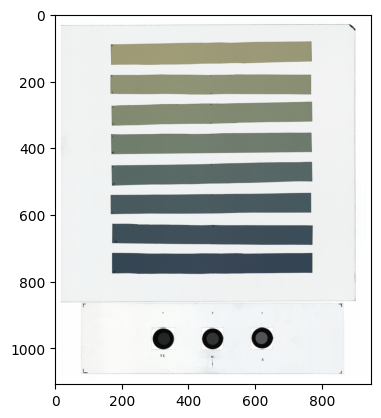

<Axes: >

In [16]:
img_m.plot()

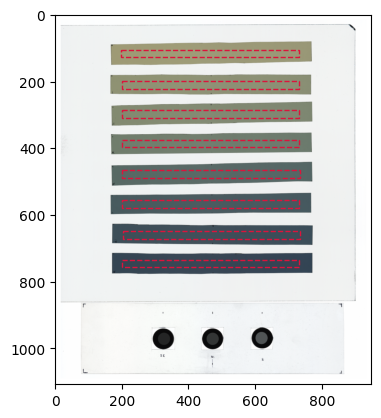

In [17]:
cal = LUT(img_m)

cal.set_central_rois(size = (180, 8))
cal.set_doses([0, 0.5, 1, 2, 4, 6, 8, 10])

cal.plot_rois()

cal.set_beam_profile("/home/luis/Dosepy/tests/unit/fixtures/CAL/BeamProfile.csv")

cal.compute_lateral_lut(filter = 5)

### Plot calibration curve, for example, at 50 mm.

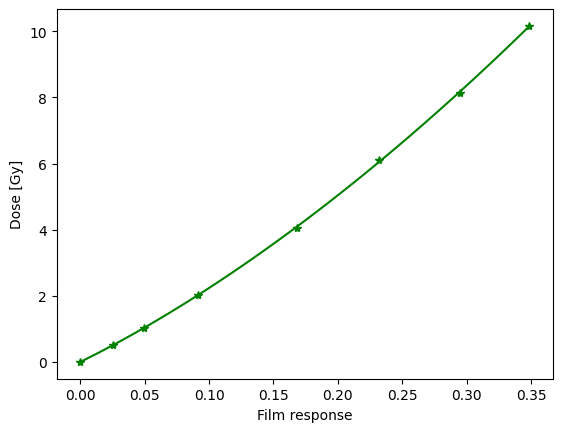

In [18]:
cal.plot_fit(
    fit="polynomial",
    channel="green",
    position=50,
    )

### Show uncertainty at different positions

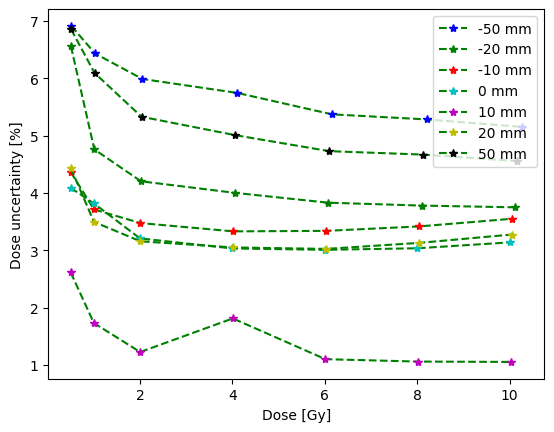

In [19]:
import matplotlib.pyplot as plt

colors = ["b", "g", "r", "c", "m", "y", "k"]
positions = [-50, -20, -10, 0, 10, 20, 50]  # In milimeters

fig, ax = plt.subplots()

for c, p in zip(colors, positions):
    cal.plot_dose_fit_uncertainty(
        position = p,
        fit="polynomial",
        channel="green",
        ax=ax,
        label=f"{p} mm",
        markeredgecolor=c,
        markerfacecolor=c,
        )

ax.legend()

In [20]:
# Clear memory
del img_m, cal_image

## Film to dose

The next image is going to be used for verification. It was irradiated with 5.0 Gy (a dose value not used for calibration).

Note

Additionaly to the film to be transformed to dose, the scanned image must also have one unirradiated. The film is used as a reference for 0 Gy.


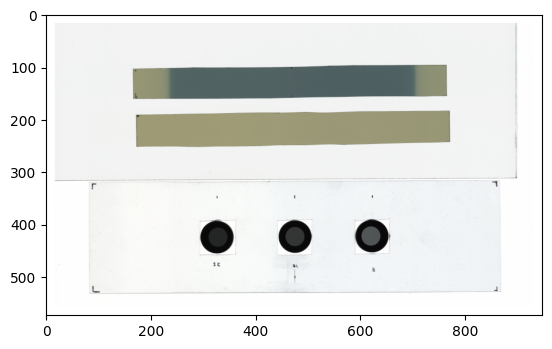

<Axes: >

In [21]:
# Load the images

files = [
    "/media/luis/TOMO/Tiff Films/EBT4/Verif 15x15/Ver_050dpi20241106_001.tif",
    "/media/luis/TOMO/Tiff Films/EBT4/Verif 15x15/Ver_050dpi20241106_002.tif",
    "/media/luis/TOMO/Tiff Films/EBT4/Verif 15x15/Ver_050dpi20241106_003.tif",
]

qa_image = load_multiples(files)
qa_image.plot()

### (Optional) Quality control using optical filters

Quality control test to check reproducibility of the scanner
using mean intensity of optical filters using red channel. 
The test pass if the intensity of the optical filters in
the image is equal to the intensity of the optical filters in the
image used for calibration, within a relative tolerance.

In [22]:
from Dosepy.calibration import passed_QC

passed_QC(img=qa_image, lut=cal, rtol=0.01)  # Relative tolerance of 1%

Intensity of optical filter(s) in calibration.
([np.float64(9345.198660714286), np.float64(13275.963083604778), np.float64(20718.336886993602)],)
Intensity of optical filter(s) in the image.
[np.float64(9429.098324022347), np.float64(13383.234273318873), np.float64(20924.68770053476)]


True

Import the tiff to dose manager. Use "RP" for red channel and a polynomial fit function.

In [23]:
from Dosepy.tiff2dose import Tiff2DoseM

t2d = Tiff2DoseM()

dose = t2d.get_dose(
    img=qa_image,
    format="RP",
    lut=cal
    )

/home/luis/miniconda3/envs/dp/lib/python3.11/site-packages/Dosepy/tools/functions.py:19: RuntimeWarning: divide by zero encountered in power
  return a*x + b*x**n
/home/luis/miniconda3/envs/dp/lib/python3.11/site-packages/Dosepy/tools/functions.py:19: RuntimeWarning: invalid value encountered in power
  return a*x + b*x**n


Plot the dose distribution

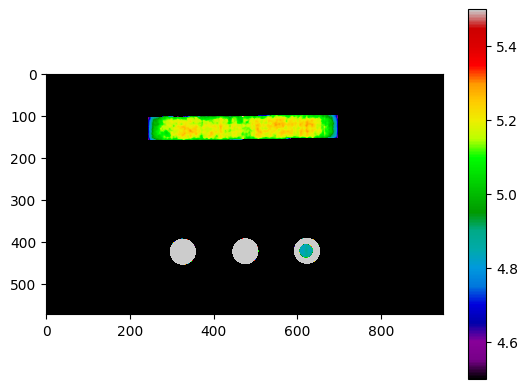

In [24]:
import matplotlib.pyplot as plt
import numpy as np


fig, ax = plt.subplots()
axeI = ax.imshow(
    dose.array,
    cmap="nipy_spectral",
    vmin=4.5,
    vmax=5.5)

fig.colorbar(axeI, ax=ax)

Save the dose distribution as a tif file (in cGy). Useful for further analysis using [ImageJ](https://imagej.net/ij/).

In [25]:
dose.save_as_tif("dose_in_tif_file")

### Dose at center

In [26]:
dose_at_center = dose.array[110:140, 450:480]
np.mean(dose_at_center)

np.float64(5.145987364646472)

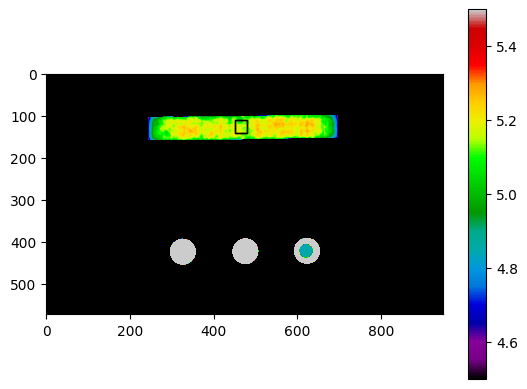

In [29]:
# Show the ROI

roi = plt.Rectangle((450, 110), 30, 30, fill=False)

ax.add_patch(roi)

fig

A difference of 0.15 Gy (3 %) is obtainded, with respect to the known dose of 5 Gy. As previously showed, it is within dose uncertainty.